 Exercice V.I.E BNP RMIR - Madrid - Joudy BENKADDOUR

---

In [1]:
!jupyter nbconvert --to pdf "Exercice_VIE_BNP_RMIR_Joudy.ipynb"

[NbConvertApp] Converting notebook Exercice_VIE_BNP_RMIR_Joudy.ipynb to pdf
[NbConvertApp] Writing 235187 bytes to Exercice_VIE_BNP_RMIR_Joudy.pdf


# Requirements

You can download the Brigo-Mercurio book here, which we are using as a reference to replicate the results for Exercise 0 and 1. https://github.com/yc-liu/readings/blob/master/Brigo%20D.%2C%20Mercurio%20F.%20Interest%20Rate%20Models%20-%20Theory%20and%20Practice.pdf

In [3]:
# Installing QuantLib library
!pip install QuantLib-Python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import QuantLib as ql

# Verify if QuantLib is imported
try:
    print("QuantLib version:", ql.__version__)
except NameError:
    print("/!\ QuantLib not imported or installed!")


QuantLib version: 1.37


In [3]:
# Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


I understand that caps pricing and calibration were not required for the interview question. However, as I was initially unfamiliar with the QuantLib library, I chose to start with a simpler product such as caps before moving on to swaptions. This approach allowed me to become more comfortable with the library and its structure. Once I realized that the framework for caps and swaptions was quite similar, I first worked on caps before proceeding to swaptions for Exercise 1. This experience has helped me better understand the library, and it will still be valuable for the swaption pricing and model calibration required for the interview.

One of the major challenges was understanding the QuantLib documentation. Most of the resources, projects, and documentation are in C++, and while there is some documentation in Python, it is not as comprehensive. Even the help function in Python provides descriptions equivalent to those in C++, which was difficult for me as a non-C++ user.

---

# Exercice 0 : Caps Pricing (Not requested)

Caps and floors are types of interest rate derivatives that provide protection against rising or falling interest rates, respectively.

A cap is a contract that can be viewed as a payer IRS where each exchange payment is executed only if it has positive value.
Analogously, a floor is equivalent to a receiver IRS where each exchange payment is executed only if it has positive value.

The cap buyer pays a premium upfront and, in return, receives payments if the underlying interest rate (for example, LIBOR or Euribor) exceeds a predetermined strike rate (cap rate) at the reset dates.

Caps are used by borrowers or investors to hedge against the risk of rising interest rates. For example, a floating-rate borrower might purchase a cap to limit the increase in their interest expenses if market rates go up.

## Set the dates and conventions

In [4]:
# The valuation date on the book is February 13, 2001 
evaluation_date = ql.Date(13, 2, 2001)
ql.Settings.instance().evaluationDate = evaluation_date
calendar = ql.TARGET()
day_count = ql.Actual360() # Discussion possible here

Here, we can discuss the day-count convention, as it may impact our subsequent computations and pricing. We will follow the Actual/360 convention, which is used for LIBOR rates and is predominantly referenced in the book and QuantLib documentation.

## Build the Zero-Coupon Yield Curve from our data

In [5]:
tenors = ["1D", "6M", "7M", "8M", "9M", "10M", "11M", "12M",
          "13M", "14M", "15M", "18M", "2Y", "3Y", "4Y", "5Y",
          "6Y", "7Y", "8Y", "9Y", "10Y", "11Y", "12Y", "15Y", "20Y",
          "25Y", "30Y"]

yields_percent = [4.8, 4.645, 4.66365, 4.63824, 4.63383, 4.59291,
                  4.60407, 4.63603, 4.56616, 4.56325, 4.55416, 4.57791,
                  4.645, 4.725, 4.805, 4.895, 4.995, 5.1, 5.182, 5.235,
                  5.302, 5.36, 5.405, 5.55, 5.685, 5.735, 5.745]

yields = [r/100.0 for r in yields_percent]

Retrieving the yield and zero-yield curve data was challenging because the book only provides a graph without a corresponding data table. 

To overcome this, I sourced the yield curve for euro rates from Bloomberg, matching the date used in the book. However, I cannot guarantee that this is the exact same curve, as the data may have been recorded at a different time of the day, leading to potential discrepancies. We will discuss these differences, but overall, while there are slight variations in levels, the general shape of the yield curve in the book closely aligns with the zero-coupon yield curve obtained from Bloomberg.

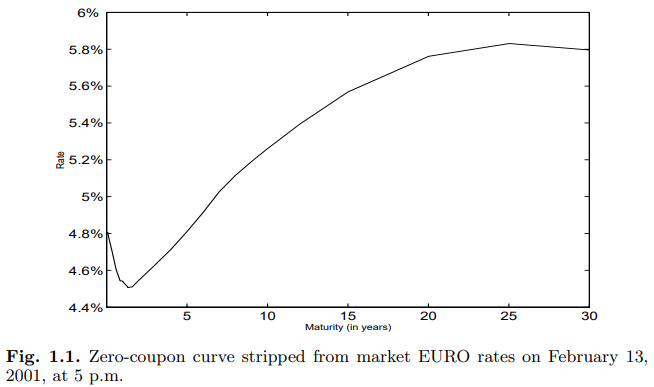

In [6]:
# Convert tenor string to QuantLib Period
def tenor_to_period(tenor_str):
    if tenor_str.endswith("D"):
        return ql.Period(int(tenor_str[:-1]), ql.Days)
    elif tenor_str.endswith("M"):
        return ql.Period(int(tenor_str[:-1]), ql.Months)
    elif tenor_str.endswith("Y"):
        return ql.Period(int(tenor_str[:-1]), ql.Years)
    else:
        raise ValueError("Unknown tenor format: " + tenor_str)

# Create dates from tenors (the dates will be relative to the evaluation date)
dates = [calendar.advance(evaluation_date, tenor_to_period(t)) for t in tenors]

# Build the zero curve and wrap it in a Handle
zero_curve = ql.ZeroCurve(dates, yields, day_count, calendar)
yield_curve_handle = ql.YieldTermStructureHandle(zero_curve)

In QuantLib, a helper is an object that encapsulates all the information required to price a market instrument such as a cap, floor, or swaption.

Internally, the helper uses a pricing engine (which is set on the helper) to compute the model price of the instrument.

A YieldTermStructureHandle is a smart pointer that wraps a yield term structure object.

## Plotting the yield curve

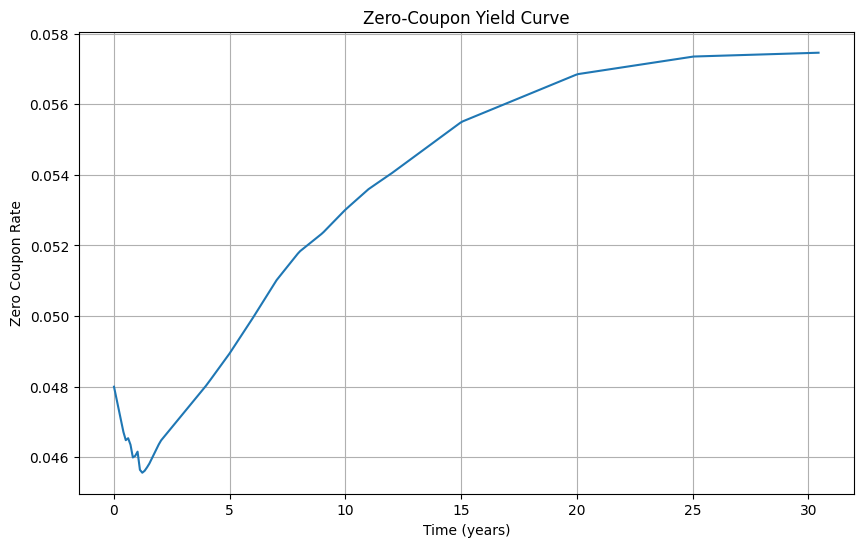

In [7]:
# Determine the time span (in years) for our plot.
max_time = day_count.yearFraction(evaluation_date, dates[-1])
min_time = day_count.yearFraction(evaluation_date, dates[0])
n_points = 300
times = np.linspace(min_time, max_time, n_points)

# For each time, extract the zero rate.
zero_rates = []
for t in times:
    days = int(round(t * 365))
    sample_date = evaluation_date + days 
    # Retrieve the zero rate from the yield curve using continuous compounding.
    # The zeroRate() method returns a RateHelper and we can call .rate() to extract the numerical rate.
    rate = yield_curve_handle.zeroRate(sample_date, day_count, ql.Continuous, ql.Annual, True).rate()
    zero_rates.append(rate)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(times, zero_rates)
plt.xlabel("Time (years)")
plt.ylabel("Zero Coupon Rate")
plt.title("Zero-Coupon Yield Curve")
plt.grid(True)
plt.show()

As mentioned earlier, the yield curve I obtained from Bloomberg is not exactly the same as the one used in the book. 

However, both share the same starting point, with very short-term yields at 4.8%. From there, we observe a slight decline to 4.5% within the first month, followed by an upward trend from the 3-month mark to the 30-year yield. This means the overall shape remains largely similar. The main difference lies in the yield levels: in the book, the curve surpasses 5.8%, whereas the Bloomberg-derived curve does not exceed that level, though it remains very close.

## Define the market cap volatilities from the book

In [8]:
# Cap maturities in years and corresponding market volatilities
cap_maturities = [1, 2, 3, 4, 5, 7, 10, 15, 20]
market_cap_vols = [0.1520, 0.1620, 0.1640, 0.1630, 0.1605,
                   0.1555, 0.1475, 0.1350, 0.1260]

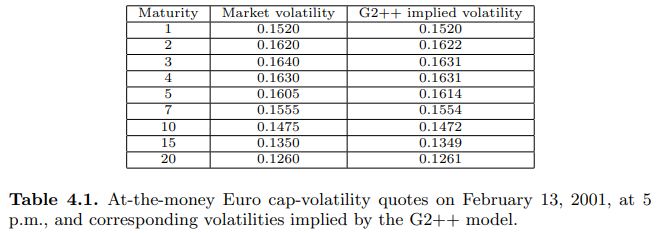

## Set up the calibration instruments using cap helpers

In [9]:
# Here, we use Euribor6M built on our yield curve.
euribor6m = ql.Euribor6M(yield_curve_handle) # Discussion

# Create cap helpers
cap_helpers = []
for m, vol in zip(cap_maturities, market_cap_vols):
    vol_quote = ql.QuoteHandle(ql.SimpleQuote(vol))
    cap_helper = ql.CapHelper(
        ql.Period(m, ql.Years), 
        vol_quote,
        euribor6m,
        ql.Semiannual,
        day_count,
        True,  # includeFirstSwaplet flag
        yield_curve_handle
    )
    cap_helpers.append(cap_helper)

The one-year cap has a period of three months, whereas the others (with maturities 2, 3, 4, 5, 7, 10, 15 and 20 years) of six months.

## Define initial parameters for the G2++ model (from the paper)

In [10]:
a_init     = 0.543009105
sigma_init = 0.005837408
b_init     = 0.075716774
eta_init   = 0.011657837
rho_init   = -0.991401219

# Instantiate the G2++ model with the initial parameters
g2_model = ql.G2(yield_curve_handle, a_init, sigma_init, b_init, eta_init, rho_init)

# Create a TreeCapFloorEngine for the G2 model.
time_steps = 50 
engine = ql.TreeCapFloorEngine(g2_model, time_steps, yield_curve_handle)

# Assign the pricing engine to each cap helper's underlying instrument
for helper in cap_helpers:
     helper.setPricingEngine(engine)

There are difficulties in understanding which pricing engine to use for caps, as there are many choices in the documentation: BlackCapFloorEngine, BachelierCapFloorEngine, AnalyticCapFloorEngine, and TreeCapFloorEngine. However, TreeCapFloorEngine is the only one that can be used for two-factor models.

## G2++ Model Presentation

### Limitations of One-Factor Models: Perfect Correlation

One common weakness of one-factor models (such as the Vasicek model) is that they assume all interest rates move together. In these models, every rate on the yield curve is perfectly correlated with the others. For example, in a one‑factor model, the thirty‑year rate and the three‑month rate at the same time are perfectly correlated. This means that if the short rate (the starting point of the curve) is shocked, the entire curve shifts almost rigidly in the same direction. 

In reality, however, interest rates for different maturities do not move exactly together; they exhibit some degree of decorrelation. For many products, like those that depend only on a single rate (say, the six‑month rate), one‑factor models may work well. But if a product depends on the relationships (correlations) between rates of different maturities, the assumption of perfect correlation is unrealistic.

### The Need for Multi-Factor Models

To capture the realistic behavior of the yield curve, multi‑factor models are used. 

Historical studies using principal component analysis have shown that, we will showcase 2 exemples quoted in the book:

For the first experience : <br>
One factor often explains only about 68% to 76% of the yield curve’s variation while two factors typically capture around 85% to 90% of the variation and three factors can explain up to 93% to 94% of the total variation. 

Another study found that one component explained 92% of the variance, but two components already captured more than 99% of it.

This means that while one factor might describe most of the movement, a second (or even a third) factor is needed to accurately model the differences among short, medium, and long-term rates. With multiple factors, the correlation between different rates is no longer forced to be 1. Instead, the model can reflect that a shock might affect short-term rates differently from long-term rates. In practice, using two or three factors offers a good balance between having enough flexibility to fit market data and keeping the model numerically efficient.

### Detailed Overview of the G2++ Model

The G2++ model is preferred for interest rate products because it accounts for mean reversion, a phenomenon where interest rate movements are typically followed by opposite changes, stabilizing around specific values.

The G2++ model is a two-factor short rate model that improves on one-factor models by capturing more realistic yield curve dynamics. Under the risk-adjusted measure $Q$, the instantaneous short rate is given by

$$
r(t) = \varphi(t) + x(t) + y(t), \quad r(0) = r_0,
$$

where:

- **$\varphi(t)$:**  
  A deterministic function chosen so that the model exactly fits the current (initial) yield curve. In particular, $\varphi(0) = r_0$.

- **$x(t)$ and $y(t)$:**  
  Two stochastic factors that follow Gaussian (normal) mean-reverting processes. Their dynamics are defined as

$$
dx(t) = -a\, x(t)\, dt + \sigma\, dW_1(t), \quad x(0) = 0,
$$

$$
dy(t) = -b\, y(t)\, dt + \eta\, dW_2(t), \quad y(0) = 0,
$$

where:
- $a$ and $b$ are positive constants representing the speeds at which $x(t)$ and $y(t)$ revert to their mean.
- $\sigma$ and $\eta$ are positive constants representing the volatilities (the sizes of the random shocks).
- $W_1(t)$ and $W_2(t)$ are two Brownian motions with instantaneous correlation, that is,

$$
dW_1(t)\, dW_2(t) = \rho\, dt,
$$

with $-1 \le \rho \le 1$.

The deterministic function $\varphi(t)$ is defined on the time interval $[0, T^*]$, where $T^*$ is a chosen time horizon (typically 10, 30, or 50 years).

At first glance, $x(t)$ and $y(t)$ look very similar. However, they are allowed to have different reversion speeds and different volatilities. This means one factor might capture short‑term fluctuations while the other captures long‑term movements. The correlation $ \rho\ $ between their driving Brownian motions lets them interact in a way that the overall movement of rates is not perfectly synchronized. In a one‑factor model, all rates move perfectly together (a correlation of 1), but with two factors, the correlation between rates of different maturities can be less than one, which is more realistic.


### Limits of the G2 Model

- **Gaussian Assumption**

- **Constant Parameter Assumption:**  
  The assumption that all model parameters remain constant over time may not reflect the actual dynamics of interest rates, which can change with economic conditions. Time-dependent extensions exist but add complexity.

- **Limited Capture of Extreme Events:**  
  The model does not incorporate features such as jumps or stochastic volatility, which might be important for capturing extreme market movements or volatility smiles.

- **Mono-Curve Framework Assumption:**  
  A key assumption of the mono-curve framework is that there is no significant spread between different tenor LIBOR rates. In other words, it assumes that short-term rates (e.g., 3-month LIBOR) and longer-term rates (e.g., 6-month LIBOR) move almost in tandem, which may not be realistic in markets where these spreads are significant.

## Calibrate the G2++ model to the cap prices (derived from the market volatilities)

When optimizing interest rate models to fit market data, several criteria can be used. 

However, the most popular loss functions include: 
- The squared weighted percentage difference between model and market Black implied volatilities
- The squared weighted percentage difference between model and market prices 
- The squared weighted difference between model and market prices standardized by the market vega 

These criteria are widely used due to their effectiveness in capturing the nuances of market behavior and ensuring accurate model calibration.

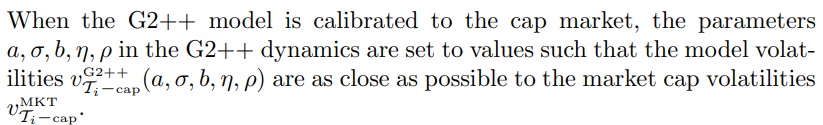

In [11]:
# Calibration minimizes the price differences, not the volatilities directly.
# The Levenberg–Marquardt algorithm is designed to solve non-linear least squares problems
# It iteratively adjusts the model parameters to minimize the sum of squared differences between the model and the market data.

optimization_method = ql.LevenbergMarquardt()
end_criteria = ql.EndCriteria(400, 100, 1e-8, 1e-8, 1e-8)
g2_model.calibrate(cap_helpers, optimization_method, end_criteria)

# Display the calibrated parameters
calibrated_params = g2_model.params()
print("Calibrated parameters:")
print("a     =", calibrated_params[0])
print("sigma =", calibrated_params[1])
print("b     =", calibrated_params[2])
print("eta   =", calibrated_params[3])
print("rho   =", calibrated_params[4])

Calibrated parameters:
a     = 0.5939554483708582
sigma = 0.005825313535744981
b     = 0.07351670340016443
eta   = 0.011716803956034251
rho   = -0.9999999567205662


We successfully obtained our newly calibrated parameters. The initial parameters were taken from the book, and we calibrated them using the prices and yield curve implemented in my code. Through optimization, we adjusted the parameters to minimize the difference between the market price and the model price. 

Fortunately, the calibrated parameters closely match those in the book, which confirms the accuracy of our calibration and optimization process. 

According to the litterature "Caps do not provide information about the correlation between forward rates, often leading to the model degenerating into a one-factor model. A frequently observed result when calibrating the model to caps (or floors) is a correlation parameter, 𝜌, close to −1." . This suggests that our approach was effective.

"The minimization is performed with a simulated-annealing method followed by a local-search algorithm to refine the last solution found."  

Some differences in our calibrated parameters could also be explained by the possibility that we used a different optimization algorithm than the one in the book.

In [12]:
print("\nCap Maturity (Years) | Market Vol | Model Implied Vol | % Diff")
for helper in cap_helpers:
    # Compute the model cap price with the helper
    model_price = helper.modelValue()
    
    # Compute the model-implied volatility from the model price
    model_vol = helper.impliedVolatility(model_price, 1e-8, 100, 1e-4, 4.0)
    
    # Retrieve the market volatility from the helper
    market_vol = helper.volatility().value()
    
    # Get the cap's maturity from the helper
    maturity = round(helper.times()[-1])

    # Compute the % error 
    perc_diff = (model_vol - market_vol) / market_vol * 100
    
    print(f"{maturity:>20.0f} | {market_vol:>10.4f} | {model_vol:>17.4f} | {perc_diff:10.2f}%")



Cap Maturity (Years) | Market Vol | Model Implied Vol | % Diff
                   1 |     0.1520 |            0.1616 |       6.32%
                   2 |     0.1620 |            0.1580 |      -2.48%
                   3 |     0.1640 |            0.1576 |      -3.91%
                   4 |     0.1630 |            0.1605 |      -1.51%
                   5 |     0.1605 |            0.1583 |      -1.37%
                   7 |     0.1555 |            0.1543 |      -0.75%
                  10 |     0.1475 |            0.1467 |      -0.51%
                  15 |     0.1350 |            0.1367 |       1.24%
                  20 |     0.1260 |            0.1288 |       2.25%


Now, we can compare the market volatility with the implied volatility from our model. While the model’s implied volatility is not a perfect match, the results are still reasonable. 

The differences range between +5% and -5%, making the comparison somewhat tricky, our values are close but not exactly the same. The discrepancy may come from differences in the zero-coupon yield structure, as we did not use the exact same one as in the book. Despite this, our numbers are fairly accurate, even if not perfect, and they remain good enough for our analysis.

---

# Exercice 1 : Swaptions pricing

A swaption is an option on an interest rate swap. In simple terms, it gives its holder the right but not the obligation to enter into a swap contract at a predetermined fixed rate on a specified future date. There are two main types:

Payer Swaption: The right to pay a fixed rate and receive a floating rate (used when you expect rates to rise). <br>
Receiver Swaption: The right to receive a fixed rate and pay a floating rate (used when you expect rates to fall).

Swaptions are widely used in hedging interest rate risk and in speculative trading on future movements in interest rates.

In [13]:
# The evaluation date remains the same as the exercice 0

In [14]:
# The yield curve also remains the same as the exercice 0

## Set up the market swaption volatility matrix

In [15]:
# Rows: swaption expiries
swaption_expiries = [1, 2, 3, 4, 5, 7, 10]

# Columns: underlying swap tenors
swap_tenors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# The swaption volatilities:
swaption_vols = [
    [0.1640, 0.1550, 0.1430, 0.1310, 0.1240, 0.1190, 0.1160, 0.1120, 0.1100, 0.1070],
    [0.1600, 0.1500, 0.1390, 0.1290, 0.1220, 0.1190, 0.1160, 0.1130, 0.1100, 0.1080],
    [0.1570, 0.1450, 0.1340, 0.1240, 0.1190, 0.1150, 0.1130, 0.1100, 0.1080, 0.1060],
    [0.1480, 0.1360, 0.1260, 0.1190, 0.1140, 0.1120, 0.1090, 0.1070, 0.1050, 0.1030],
    [0.1400, 0.1280, 0.1210, 0.1140, 0.1100, 0.1070, 0.1050, 0.1030, 0.1020, 0.1000],
    [0.1300, 0.1190, 0.1130, 0.1050, 0.1010, 0.0990, 0.0970, 0.0960, 0.0950, 0.0930],
    [0.1160, 0.1070, 0.1000, 0.0930, 0.0900, 0.0890, 0.0870, 0.0860, 0.0850, 0.0840]
]

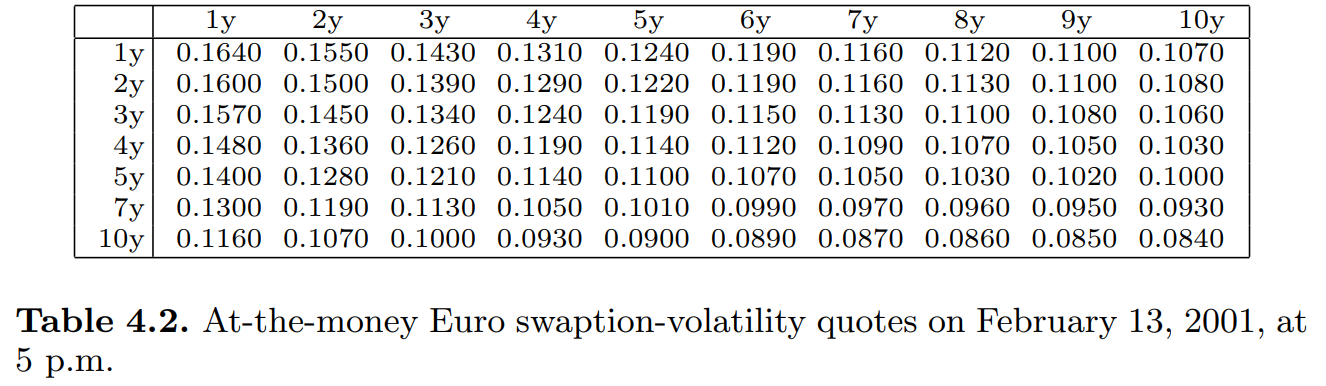

## Creation of a list of SwaptionHelper objects

In [16]:
swaption_helpers = []
swaption_info = []

# Use the same day count convention for the fixed leg as for the discounting
fixed_leg_tenor = ql.Period(6, ql.Months)  # Semi-annual payments (discussion)
fixed_leg_daycount = day_count
floating_leg_daycount = day_count

for i, expiry in enumerate(swaption_expiries):
    for j, tenor in enumerate(swap_tenors):
        vol = swaption_vols[i][j]
        vol_quote = ql.QuoteHandle(ql.SimpleQuote(vol))
        helper = ql.SwaptionHelper(
            ql.Period(expiry, ql.Years),
            ql.Period(tenor, ql.Years),
            vol_quote,
            euribor6m,
            fixed_leg_tenor,
            fixed_leg_daycount,
            floating_leg_daycount,
            yield_curve_handle,
            ql.BlackCalibrationHelper.RelativePriceError
        )
        swaption_helpers.append(helper)
        swaption_info.append((expiry, tenor))

I couldn’t find the specifications and conventions of the swaption we are studying in the book, so I made my own assumptions. I considered it as a swap with semi-annual payments based on Euribor rates.

## Create the G2++ model using initial parameters

In [17]:
# From the paper’s swaption calibration just below table 4.2
a_init     = 0.773511777
sigma_init = 0.022284644
b_init     = 0.082013014
eta_init   = 0.010382461
rho_init   = -0.701985206

g2_model = ql.G2(yield_curve_handle, a_init, sigma_init, b_init, eta_init, rho_init)


## Assign an analytic engine for G2++ model on swaptions 

In [18]:
'''
# Use a tree-based pricing engine for swaptions.
time_steps = 50
engine = ql.TreeSwaptionEngine(g2_model, time_steps, yield_curve_handle)
'''

range_integration = 4.0   # Cover ±4 standard deviations
n_intervals = 500
engine = ql.G2SwaptionEngine(g2_model, range_integration, n_intervals)


## Set the pricing engine for each swaption helper.

In [19]:
for helper in swaption_helpers:
    helper.setPricingEngine(engine)

## Calibrate the G2++ model to the swaption prices

In [20]:
optimization_method = ql.LevenbergMarquardt()
end_criteria = ql.EndCriteria(400, 100, 1e-8, 1e-8, 1e-8)
g2_model.calibrate(swaption_helpers, optimization_method, end_criteria)

## Retrieve and display the calibrated parameters.

In [21]:
calibrated_params = g2_model.params()

print("Calibrated parameters:")
print("a     =", calibrated_params[0])
print("sigma =", calibrated_params[1])
print("b     =", calibrated_params[2])
print("eta   =", calibrated_params[3])
print("rho   =", calibrated_params[4])

Calibrated parameters:
a     = 1.5564904073641272
sigma = 0.035103525533549076
b     = 0.07273088963349983
eta   = 0.009332240739764614
rho   = -0.6573821867138078


### 1. Higher Mean-Reversion Strength in the First Factor ($ a $)

One of the most striking differences is that the calibrated value of the mean-reversion parameter $ a $ is approximately **twice** as large as the value reported in the reference model. This suggests that in our dataset, the first stochastic factor reverts to its mean at a much faster rate than in the book's calibration. A higher mean-reversion speed generally implies that short-term fluctuations dissipate more quickly, leading to a smoother evolution of the short rate over time.

### 2. Increased Volatility in the First Factor ($ \sigma $)

Similarly, we observed that the volatility parameter $ \sigma $ is about **50% higher** in our model compared to the reference. This means that rate fluctuations are larger in magnitude in our market environment than in the dataset used in the book. This could be due to differences in market conditions, a higher level of interest rate uncertainty, or specific features of the instruments used in our calibration.

### 3. Consistency in the Second Factor ($ b, \eta $)

Interestingly, the parameters of the second stochastic factor ($ b $ and $ \eta $) are almost identical to those in the book. The consistency of these values reinforces the idea that the second factor primarily captures the slower, structural movements of the yield curve, which tend to be more stable over time.

### 4. Correlation Between the Two Brownian Motions ($ \rho $)

Our calibration resulted in a correlation coefficient $ \rho $ of approximately **0.7**, which aligns closely with both the reference model and values commonly found in the literature. This result is particularly important because it confirms that the two factors are not moving in perfect opposition (i.e., $ \rho \neq -1 $). A correlation around 0.7 suggests that the factors exhibit a meaningful but not excessive relationship, allowing the model to better capture realistic interest rate movements.

### 5. Interpretation of the Results

The differences in the calibrated parameters compared to the book suggest that market conditions at the time of our calibration exhibit stronger short-term fluctuations and faster mean reversion than in the reference dataset. However, the long-term dynamics remain relatively unchanged, as reflected by the stability of the second factor’s parameters.

These findings highlight the flexibility of the G2++ model in adapting to different market environments while preserving fundamental characteristics observed in theoretical and empirical studies.


## Compare market vs. model swaption volatilities

In [22]:
# Create dictionaries to store model volatilities and percentage differences
model_vol_dict = {}
perc_diff_dict = {}

# Iterate through the swaptions to collect data
for (expiry, tenor), helper in zip(swaption_info, swaption_helpers):
    model_price = helper.modelValue()
    
    # Compute model implied volatility and percentage difference
    model_vol = helper.impliedVolatility(model_price, 1e-4, 100, 1e-4, 4.0)
    market_vol = helper.volatility().value()
    perc_diff = (model_vol - market_vol) / market_vol * 100
    
    # Store values in dictionaries
    if expiry not in model_vol_dict:
        model_vol_dict[expiry] = {}
        perc_diff_dict[expiry] = {}
    
    model_vol_dict[expiry][tenor] = model_vol
    perc_diff_dict[expiry][tenor] = perc_diff

# Convert dictionaries to DataFrames (maturities as index, tenors as columns)
model_vol_df = pd.DataFrame.from_dict(model_vol_dict, orient='index').sort_index()
perc_diff_df = pd.DataFrame.from_dict(perc_diff_dict, orient='index').sort_index()

### Our G2++ Calibrated vs. Brigo-Mercurio swaptions volatilities

In [23]:
model_vol_df

,1,2,3,4,5,6,7,8,9,10
1,0.180558,0.144218,0.136376,0.132176,0.127934,0.123413,0.119409,0.116073,0.112404,0.109003
2,0.160412,0.142511,0.136558,0.131585,0.126519,0.122155,0.118584,0.114634,0.110996,0.107801
3,0.152457,0.138313,0.131984,0.126513,0.122065,0.118512,0.114472,0.110760,0.107512,0.104290
4,0.143589,0.131336,0.125109,0.120799,0.117491,0.113496,0.109829,0.106572,0.103348,0.100250
5,0.134208,0.123545,0.119156,0.116208,0.112314,0.108719,0.105522,0.102301,0.099188,0.096196
7,0.121733,0.116068,0.111376,0.107634,0.104490,0.101146,0.097873,0.094735,0.092274,0.089902
10,0.108787,0.103538,0.099834,0.096414,0.093094,0.090714,0.088288,0.085877,0.083563,0.081336


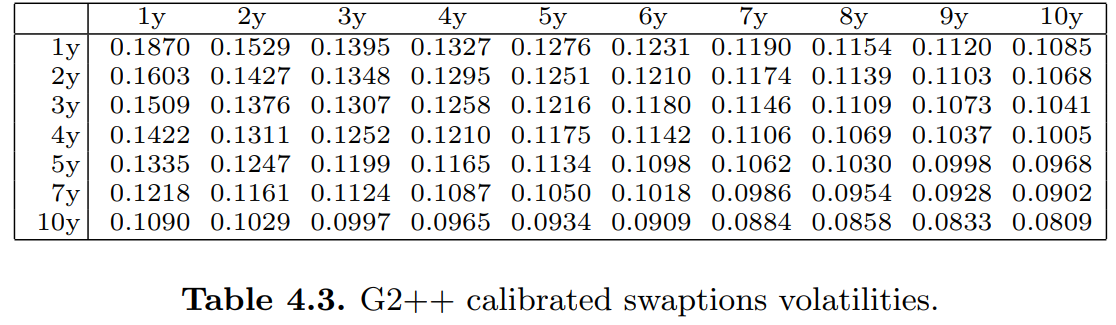

### Our G2++ Calibrated vs. Brigo-Mercurio percentage differences on swaptions volatilities

In [24]:
perc_diff_df

,1,2,3,4,5,6,7,8,9,10
1,10.096154,-6.955917,-4.631934,0.897965,3.172749,3.708536,2.938789,3.636933,2.185797,1.871503
2,0.257307,-4.992724,-1.757104,2.004114,3.704006,2.651093,2.227516,1.445683,0.905336,-0.184668
3,-2.893745,-4.611547,-1.504731,2.026435,2.575901,3.053838,1.302880,0.690925,-0.452231,-1.613430
4,-2.980681,-3.429409,-0.707143,1.512017,3.062666,1.336079,0.760140,-0.399660,-1.573003,-2.670194
5,-4.137357,-3.480766,-1.523821,1.936468,2.103773,1.606184,0.497223,-0.678924,-2.756489,-3.803907
7,-6.359361,-2.463522,-1.437523,2.508352,3.455638,2.167350,0.900333,-1.317637,-2.869243,-3.330902
10,-6.217933,-3.235750,-0.166225,3.671463,3.438200,1.925875,1.480692,-0.142956,-1.690546,-3.171279


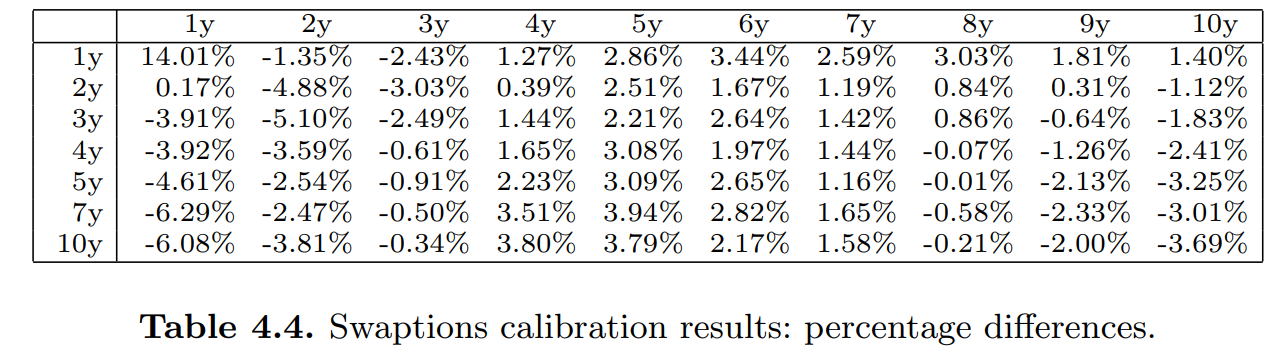

### Observations on Percentage Differences

One key observation is that both our results and those from the book show **higher errors for short-expiry options**, particularly for the **1-year expiry, 1-year tenor swaptions**. The percentage difference in these cases is significantly larger than for longer maturities. This suggests that short-term swaptions are more challenging to fit accurately using the G2++ model.

Across the entire dataset:
- Our model’s percentage differences range **from -6% to +6%**, with **higher uncertainty in short-expiry options**.
- The further out the expiry of the swaption, the **more precise the model becomes**
- The **overall precision of our model appears slightly lower than that in the book**, as our differences are somewhat larger on average.

### No Clear Pattern in Errors

Given that we are comparing approximately **70 different swaptions**, identifying a consistent pattern in the errors is challenging. While we see a general trend of **better accuracy for longer expiries**, there is no obvious structure in how our model deviates from the market beyond that. The differences appear to be scattered, making it difficult to pinpoint a systematic bias.

### Conclusion

Overall, our calibration results are **reasonably close** to those in the reference model, but with **slightly higher errors on average**. The G2++ model remains a strong candidate for interest rate modeling, though its precision varies depending on the expiry of the swaptions. Further refinement of the calibration procedure, such as incorporating different weightings or refining the optimization process, could help reduce the discrepancies observed in short-term swaptions.

To further enhance the analysis, a joint calibration to both caps and swaptions data can be attempted.

---

# Exercice 2 : Assessment of calibration uncertainty

## Review the Model and its Properties

The **Black–Karasinski model** is a one-factor model typically used for interest rate modelling and is also used to compute the prices of caps, floors, and swaptions. It can be adapted to model credit spreads as well. In our simplified version, we assume that the logarithm of the credit spread is defined as:

$$
x(t) = \ln S(i,t),
$$

and that it follows a mean-reverting process:

$$
dx(t) = \kappa \Bigl( m - x(t) \Bigr) \, dt + \sigma \, dW_t,
$$

where $\kappa$ represents the mean reversion speed, and the "long-term mean" is given by:

$$
m = \ln \theta - \frac{\sigma^2}{4\kappa}.
$$

The model implies a log-normal distribution for the short rate because the process for $S(i,t)$ is obtained by exponentiating the normally distributed $x(t)$. Although the underlying process for $x(t)$ is Gaussian, the exponentiation ensures that $S(i,t)$ remains positive, resulting in a log-normal distribution for the short rate.




## Solution of the SDE

Since $x(t)$ is an Ornstein–Uhlenbeck process, its exact solution between $t_0$ and $t$ is:

$$
x(t) = m + \left( x(t_0) - m \right) e^{-\kappa (t-t_0)} + \sigma \int_{t_0}^{t} e^{-\kappa (t-s)} \, dW_s.
$$

The stochastic integral is normally distributed with zero mean and variance:

$$
\frac{\sigma^2}{2\kappa} \left( 1 - e^{-2\kappa (t-t_0)} \right).
$$

Thus, for a discretized time step $\Delta t = t-t_0$, we can write:

$$
x(t_0+\Delta t) = m + \left( x(t_0)-m \right) e^{-\kappa \Delta t} + \sqrt{ \frac{\sigma^2}{2\kappa} \left( 1 - e^{-2\kappa \Delta t} \right) } \, Z,
$$

or 

$$
x(t_0+\Delta t) = e^{-\kappa\Delta t}\, x(t_0) + m\left(1 - e^{-\kappa\Delta t}\right) + \sqrt{\frac{\sigma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t}\right)}\, Z,
$$

where $Z \sim \mathcal{N}(0,1)$. Finally, since

$$
S(i,t) = \exp\{x(t)\},
$$

the solution for $S(i,t)$ is given by exponentiating the solution for $x(t)$.

## Simplifications in the Exercise and Their Impact on the Code

Below is a summary of every simplification made in the exercise along with an explanation of its impact on our implementation.

### 1. Disregarding the Tenor Dimension
- **Meaning:**  
  Instead of modeling an entire curve of credit spreads (i.e., multiple tenors) for each issuer, we assume there is only one credit spread value per issuer.
- **Impact on the Code:**  
  - The simulated data is represented as a 2D array of shape $(n\_steps+1) \times n\_paths$, where each column represents a single issuer’s spread over time.
  - This greatly simplifies data handling and visualization, since we are not dealing with a 3D array (which would be required if we modeled spreads across multiple tenors).

### 2. Uniform Model Parameters Across Issuers
- **Meaning:**  
  Every issuer in the pool uses the same set of parameters, i.e., the mean reversion speed $\kappa$, long-term level $\theta$, and volatility $\sigma$ are identical for all.
- **Impact on the Code:**  
  - The same values of $\kappa$, $\theta$, and $\sigma$ are used in the simulation for every issuer.
  - There is no need for issuer-specific parameter handling, thus simplifying the simulation process.

### 3. No Correlation Between Issuers
- **Meaning:**  
  The credit spread returns for different issuers are assumed to be uncorrelated.
- **Impact on the Code:**  
  - Each issuer's path is simulated independently by drawing separate random numbers (from a standard normal distribution).
  - There is no need to construct and manage a covariance matrix or model correlations between different issuers, resulting in a simpler simulation loop.

### 4. Volatility Estimation as if Returns Are from a Brownian Motion
- **Meaning:**  
  Although the Black–Karasinski model is a mean-reverting process, for simplicity, we assume that the log returns behave like those from a pure Brownian motion, where the variance scales linearly with time (i.e., $\sigma^2 \Delta t$).
- **Impact on the Code:**  
  - In the volatility calibration step, we calculate the standard deviation of the log returns and divide by $\sqrt{dt}$:
    $$
    \hat{\sigma} = \frac{\text{std(returns)}}{\sqrt{dt}}.
    $$
  - This bypasses the complexity of accounting for the mean-reversion correction factor in the variance and provides a simpler estimation of volatility.


In [25]:
def simulate_black_karasinski(S0, kappa, theta, sigma, dt, n_steps, n_paths):
    """
    Simulates the Black-Karasinski process for credit spreads.
    
    Parameters:
      S0      : Initial credit spread
      kappa   : Mean reversion speed
      theta
      sigma   : Volatility parameter
      dt      : Time increment (1/252 for daily steps)
      n_steps : Number of time steps
      n_paths : Number of issuers (independent paths)
      
    Returns:
      S       : A (n_steps+1 x n_paths) array of simulated spreads.
    """
    # Compute the long-term mean
    m = np.log(theta) - sigma**2 / (4 * kappa)
    
    # Set the initial condition
    x = np.zeros((n_steps + 1, n_paths))
    x[0, :] = np.log(S0)  
    
    # Compute factors
    exp_kappa_dt = np.exp(-kappa * dt)
    sqrt_variance = np.sqrt((sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt)))
    
    # Simulate the process
    for t in range(n_steps):
        z = np.random.normal(size=n_paths)
        x[t+1, :] = m + (x[t, :] - m) * exp_kappa_dt + sqrt_variance * z
        
    # Transform the log spreads back to spread levels
    S = np.exp(x)
    return S

In [26]:
def calibrate_volatility_per_company(S, dt):
    """
    Estimates the volatility for each issuer individually from the simulated spread paths.
    
    Parameters:
      S  : 2D array of simulated spreads (time steps x issuers)
      dt : Time increment used in the simulation
      
    Returns:
      sigma_est : 1D array containing the re-estimated volatility for each issuer.
    """

    # Compute the log of spreads
    log_S = np.log(S)
    # Calculate log returns for each issuer (each column)
    returns = np.diff(log_S, axis=0)

    # Compute the volatility for each issuer:
    # ddof=1 uses N-1 for an unbiased estimate,
    # and we divide by sqrt(dt) to annualize the volatility.
    sigma_est = np.std(returns, axis=0, ddof=1) / np.sqrt(dt)
    return sigma_est

In this exercise, the volatility parameter is interpreted as the annual volatility. This means that the value of $\sigma$ is expressed on a yearly basis. For simplicity, I decided to use a daily time step for the simulation. Specifically, I set the time step $dt$ to be equal to $\frac{1}{365}$. <br> Consequently, the number of time steps in the simulation corresponds directly to the number of days being modeled. This approach aligns the time scale of the simulation with the annual volatility, making the results easier to interpret.


In [27]:
# Simulation parameters
S0      = 0.05      # Initial credit spread, 5 bps seems to be high enough to prevent negative spread 
kappa   = 0.5       # Mean reversion speed
theta   = 0.04
sigma   = 0.1       # Model yearly volatility parameter
n_steps = 365       # Simulate one year
dt      = 1/n_steps # Daily time steps

n_paths = 50        # Number of issuers

# Simulate credit spreads for all issuers
S = simulate_black_karasinski(S0, kappa, theta, sigma, dt, n_steps, n_paths)

# Estimate the volatility for each issuer individually
sigma_estimated = calibrate_volatility_per_company(S, dt)

# Create a final DataFrame with the results
companies = np.arange(1, n_paths + 1)
df = pd.DataFrame({
    'Company': companies,
    'Model Volatility': sigma,  # same for all issuers
    'Re-Estimated Volatility': sigma_estimated
})

# Calculate the evolution rate (percentage difference) between the re-estimated volatility and the model volatility
df['Evolution Rate (%)'] = ((df['Re-Estimated Volatility'] - df['Model Volatility']) 
                            / df['Model Volatility']) * 100

# Display the final DataFrame
df.head(10)

,Company,Model Volatility,Re-Estimated Volatility,Evolution Rate (%)
0,1,0.1,0.095047,-4.952707
1,2,0.1,0.098540,-1.459990
2,3,0.1,0.101577,1.576949
3,4,0.1,0.101420,1.420092
4,5,0.1,0.103122,3.122358
5,6,0.1,0.100776,0.776139
6,7,0.1,0.095769,-4.230786
7,8,0.1,0.100200,0.200064
8,9,0.1,0.107248,7.247619
9,10,0.1,0.106993,6.992518


In [28]:
# Output results
print("\nMean estimated volatility:", np.mean(df['Re-Estimated Volatility']))
print("Standard deviation of estimates (calibration uncertainty):", np.std(df['Re-Estimated Volatility'], ddof=1))


Mean estimated volatility: 0.10006317642014545
Standard deviation of estimates (calibration uncertainty): 0.003687145453003401


As expected, the mean of our estimated volatility is very close to the input volatility, which confirms that we have correctly implemented and calibrated the model. However, it is also interesting to explore how the number of simulations and the chosen time step affect the standard deviation of our volatility estimates. Investigating these aspects provides valuable insights into the calibration uncertainty, helping us understand how simulation parameters impact the reliability and robustness of our model's output.

---

---

# Quote

“a 1% error in the zero-coupon bond price may lead to a 25% error in an option price" - Hull and White (2009 page. 678)